<a href="https://colab.research.google.com/github/wenxuan0923/My-notes/blob/master/Transformer_concise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment Analysis with Transformer (Concise)

This note covers a Transformer model for sentiment prediction problem using Keras and Tensorflow. This is a concise version of the step-by-step guide in <a target='_blank' href='#'>this</a> note. 

In [0]:
con# Set up
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
vocab_size = 20000
maxlen = 200
(x_train, y_train), (x_val, y_val) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

In [0]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(25000, 200)
(25000,)
(25000, 200)
(25000,)


The source code of `layers.Layer` class is <a target='_blank' href='https://github.com/keras-team/keras/blob/7a39b6c62d43c25472b2c2476bd2a8983ae4f682/keras/engine/base_layer.py#L36'>here</a>





In [0]:
class Embedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super().__init__()
    self.maxlen = maxlen
    self.word_embed = layers.Embedding(vocab_size, embed_dim)
    self.position_embed = layers.Embedding(maxlen, embed_dim)
  
  def call(self, inputs):
    word_emb = self.word_embed(inputs)
    positions = np.array(range(self.maxlen))
    position_emb = self.position_embed(positions)
    return word_emb + position_emb

In [0]:
class MultiHeadAttention(layers.Layer):
  def __init__(self, maxlen, num_heads, embed_dim):
    super().__init__()
    self.maxlen = maxlen
    self.num_heads = num_heads
    self.projection_dim = embed_dim // num_heads
    self.query_dense = layers.Dense(embed_dim)
    self.key_dense = layers.Dense(embed_dim)
    self.value_dense = layers.Dense(embed_dim)
    self.combine_heads = layers.Dense(embed_dim)

  def split_heads(self, x):
    x = tf.reshape(x, (-1, self.maxlen, 
                       self.num_heads, 
                       self.projection_dim)) 
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    return x
  
  def calc_attention(self, Q, K, V):
    dimension_k = tf.cast(K.shape[-1], tf.float32)
    scores = tf.matmul(Q, K, transpose_b=True)/tf.math.sqrt(dimension_k)
    weights = Activation('softmax', name='self-attention')(scores)
    attention = tf.matmul(weights, V)
    attention = tf.transpose(attention, perm=[0, 2, 1, 3])
    concat_attention = tf.reshape(attention, (-1, self.maxlen, 
                                              self.num_heads*self.projection_dim))
    return concat_attention

  def call(self, inputs):
    Q = self.query_dense(inputs)
    K = self.key_dense(inputs)
    V = self.value_dense(inputs)

    Q = self.split_heads(Q)
    K = self.split_heads(K)
    V = self.split_heads(V)

    concat_attention = self.calc_attention(Q, K, V)
    outputs = self.combine_heads(concat_attention)
    return outputs


In [0]:
class TransformerEncoder(layers.Layer):
  def __init__(self, maxlen, num_heads, vocab_size, 
               embed_dim, ff_dim, dropout_rate):
    super().__init__()
    self.emb = Embedding(maxlen, vocab_size, embed_dim)
    self.attention = MultiHeadAttention(maxlen, num_heads, embed_dim)
    self.ff = keras.Sequential([layers.Dense(ff_dim, activation="relu"),
                                layers.Dense(embed_dim),])
    self.norm1 = layers.LayerNormalization(epsilon=1e-6)
    self.norm2 = layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = layers.Dropout(dropout_rate)
    self.dropout2 = layers.Dropout(dropout_rate)

  def call(self, inputs):
    embeded_inputs = self.emb(inputs)
    multiHead_output = self.attention(embeded_inputs)
    out1 = self.dropout1(multiHead_output)
    out1 = self.norm1(out1 + embeded_inputs)
    feed_forword_output = self.ff(out1)
    out2 = self.dropout2(feed_forword_output)
    out2 = self.norm2(out2 + out1)
    return out2

In [0]:
embed_dim = 32       # Dimension of Embedding layers
num_heads = 2        # Number of heads for multi-head attention model
ff_dim = 32          # Dimension of feed forward network
dropout_rate = 0.1

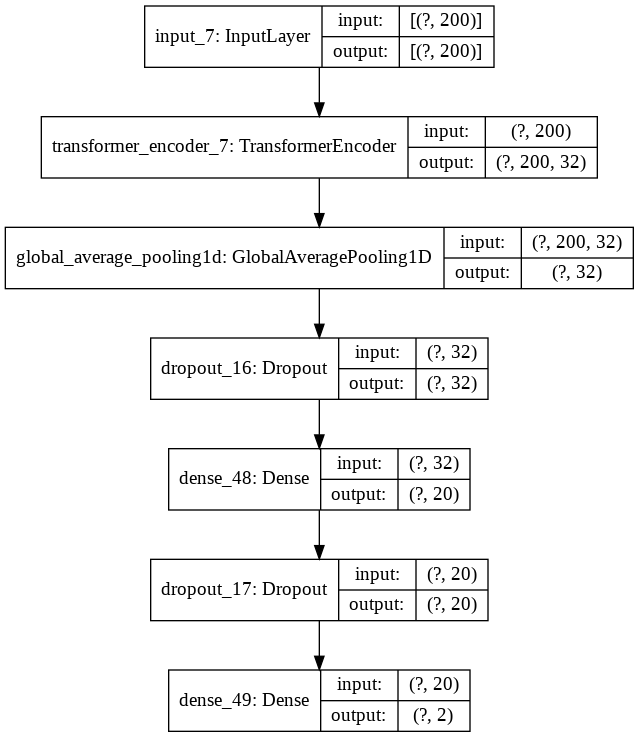

In [0]:
# Sentiment Prediction Model
inputs = keras.Input(shape=(maxlen,))
Encoder = TransformerEncoder(
    maxlen, num_heads, vocab_size, 
    embed_dim, ff_dim, dropout_rate)
x = Encoder(inputs)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
keras.utils.plot_model(model, "sentimen_model.png", show_shapes=True)

In [0]:
model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    x_train, y_train, 
    batch_size=32, 
    epochs=2, 
    validation_data=(x_val, y_val)
)

Epoch 1/2
782/782 [==============================] - 94s 120ms/step - loss: 0.3837 - accuracy: 0.8226 - val_loss: 0.3213 - val_accuracy: 0.8632
Epoch 2/2
782/782 [==============================] - 94s 120ms/step - loss: 0.2011 - accuracy: 0.9233 - val_loss: 0.3170 - val_accuracy: 0.8671
